# 0. Import the libraries

In [22]:
#export
from pathlib import Path, PosixPath
import mimetypes
import pandas as pd
import os
import PIL.Image

from collections.abc import Iterable

from torch.utils.data import DataLoader

from functools import partial

import numpy as np
import torch

import matplotlib.pyplot as plt

# 1. Load the data and the labels

In [2]:
path = PosixPath('/home/eross/.fastai/data/imagenette-160')

In [3]:
#export
Path.ls = lambda self: list(self.iterdir())

In [4]:
path.ls()

[PosixPath('/home/eross/.fastai/data/imagenette-160/train'),
 PosixPath('/home/eross/.fastai/data/imagenette-160/val')]

In [5]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res
                
def get_files(path, recurse=False, extensions=None, include=None):
    path = Path(path)
    extensions = set(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)
                
def extensions_mime(ext):
    return frozenset(k for k,v in mimetypes.types_map.items() if v.startswith(ext))
                
EXTENSIONS_IMAGE = extensions_mime('image/')
EXTENSIONS_AUDIO = extensions_mime('audio/')
EXTENSIONS_VIDEO = extensions_mime('video/')
                
def img_get_files(path, recurse=False, extensions=None, include=None):
    if extensions is None: extensions = EXTENSIONS_IMAGE
    return get_files(path, recurse, extensions, include)

In [6]:
image_paths = img_get_files(path, True)
image_paths[:5]

[PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10026.JPEG'),
 PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10027.JPEG'),
 PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10029.JPEG'),
 PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10040.JPEG'),
 PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10042.JPEG')]

In [7]:
df = (pd
   .DataFrame(image_paths, columns=['path'])
   .assign(label=lambda df: df.path.apply(lambda x: x.parent.name),
           split=lambda df: df.path.apply(lambda x: x.parent.parent.name),
           train=lambda df: df.split == 'train')
)
df.head()

path      label  split  train
0  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True
1  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True
2  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True
3  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True
4  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True

In [8]:
(df
 .groupby('label')
 .train
 .agg(['sum', lambda x: (~x).sum()])
 .set_axis(['train', 'val'], axis=1, inplace=False)
 .T
)

label  n01440764  n02102040  n02979186  n03000684  n03028079  n03394916  \
train     1300.0     1300.0     1300.0     1194.0     1300.0     1300.0   
val         50.0       50.0       50.0       50.0       50.0       50.0   

label  n03417042  n03425413  n03445777  n03888257  
train     1300.0     1300.0     1300.0     1300.0  
val         50.0       50.0       50.0       50.0

# 2. Define Image Processing Functions

In [9]:
#export
# Compose and apply: Called compose in dl2v3 lectures
def comply(functions, x, reverse=False):
    if reverse: functions = reversed(functions)
    for f in functions:
        x = f(x)
    return x

It would probably be "nicer" to make all of these classes: but it's good to know you can use quick-and-dirty functions for prototyping.

In [10]:
#export
img_open = PIL.Image.open

def img_rgb(item): return item.convert('RGB')

def img_resize(item, size, method=PIL.Image.LANCZOS):
    return item.resize(size if isinstance(size, Iterable) else (size, size),
                       method)

def img_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.

def img_from_float(x, mode="RGB"): 
    c, h, w = x.shape
    assert c == len(mode), f"Mode {mode} doesn't agree with channels {c}"
    return PIL.Image.frombytes(mode, (w,h), bytes((x*255.).permute(1,2,0).contiguous().view(-1).byte()))

Check the functions work

(213, 160)


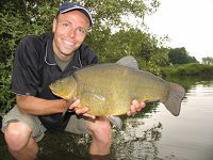

In [11]:
img = img_open(image_paths[1])
print(img.size)
img

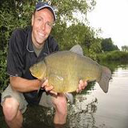

In [12]:
img_resize(img, 128)

In [13]:
img_to_float(img).shape

torch.Size([3, 160, 213])

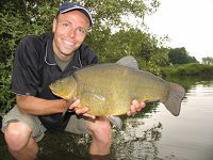

In [14]:
img_from_float(img_to_float(img))

In [15]:
assert torch.allclose(img_to_float(img), img_to_float(img_from_float(img_to_float(img))))

In [16]:
assert torch.allclose(img_to_float(img), img_to_float(img_rgb(img)))

(240, 160)


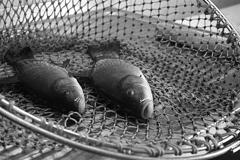

In [17]:
img = img_open(image_paths[407])
print(img.size)
img

In [18]:
img_to_float(img).shape

RuntimeError: number of dims don't match in permute

In [19]:
img_to_float(img_rgb(img)).shape

torch.Size([3, 160, 240])

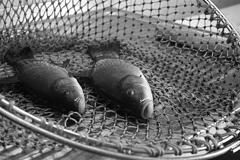

In [20]:
img_from_float(img_to_float(img_rgb(img)))

Looks good

Let's make sure we can plot a batch and normalize

In [23]:
img_tfms = [img_open, partial(img_resize, size=128), img_rgb, img_to_float]

In [24]:
batch = torch.stack([comply(img_tfms, p) for p in image_paths[:4]])
batch.shape

torch.Size([4, 3, 128, 128])

In [25]:
def _img_plot(ax, img, title=None):
    ax.axis('off')
    ax.imshow(img.permute(1,2,0))
    if title is not None:
        ax.set_title(title)

In [26]:
#export
def img_batch_plot(batch, titles=None, nrows=2, ncols=2):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    fig.tight_layout()
    axs = [ax for row in axs for ax in row] # Flatten
    titles = titles or [None for _ in axs]
    for img, ax, title in zip(batch, axs, titles):
        _img_plot(ax, img, title)

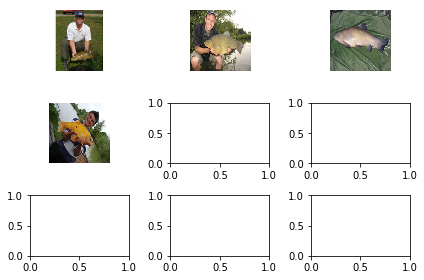

In [27]:
img_batch_plot(batch, nrows=3, ncols=3)

In [29]:
#export
class ImgNormalize:
    def __init__(self, mean=None, sd=None, batch=True):
        self.shape = (1, -1, 1, 1) if batch else (-1, 1, 1)
        self.mean = mean
        self.sd = sd
        
    def get_stats(self, items):
        assert self.mean is None and self.sd is None, "Stats already calculated"
        n = 0
        mean = 0
        sd = 0
        for item in items:
            n += 1
            item = item.view(item.shape[0], -1)
            mean += item.mean(1)
            sd += item.std(1)
        self.mean = (mean / n).view(self.shape)
        self.sd = (sd / n).view(self.shape)
        return self
        
    def __call__(self, item):
        return (item - self.mean) / self.sd
    
    def invert(self, item):
        return item * self.sd + self.mean

In [30]:
%time normalize = ImgNormalize().get_stats(comply(img_tfms, x) for x in df.path[df.train].sample(n=min(1000, sum(df.train))))
normalize.mean.flatten(), normalize.sd.flatten()

CPU times: user 3.11 s, sys: 656 ms, total: 3.77 s
Wall time: 4.12 s


(tensor([0.4646, 0.4608, 0.4327]), tensor([0.2356, 0.2299, 0.2398]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


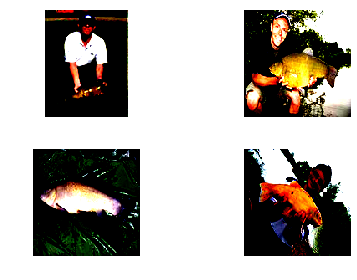

In [31]:
img_batch_plot(normalize(batch))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


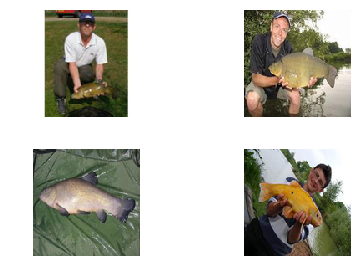

In [34]:
img_batch_plot(normalize.invert(normalize(batch)))

In [40]:
assert torch.allclose(batch, normalize.invert(normalize(batch)), atol=1e-7)

# 3. Define the Label Processing functions

In [41]:
#export
def is_unique(x):
    return len(x) == len(set(x))

In [42]:
#export
class CatNormalize:
    def __init__(self, c2i=None):
        self.c2i = c2i
        if c2i is not None and is_unique(c2i.values()):
            self.i2c = {i:c for c, i in c2i.items()}
    
    def get_stats(self, items):
        assert self.c2i is None, 'Already Initialised'
        self.c2i = {c:i for i, c in enumerate(set(items))}
        self.i2c = {i:c for c, i in self.c2i.items()}
        return self
        
    def __call__(self, item, batch=False):
        if not batch: item = [item]
        ans = [self.c2i[i] for i in item]
        if not batch: ans = ans[0]
        return torch.tensor(ans, dtype=torch.long)
    
    def invert(self, item, batch=False):
        if not batch: item = [item]
        ans = [self.i2c[i.item()] for i in item]
        if not batch: ans = ans[0]
        return ans

In [43]:
cat_norm = CatNormalize().get_stats(df.label[df.train])
x = df.label.sample(10)
list(zip(x, cat_norm(x, batch=True)))

[('n03445777', tensor(2)),
 ('n03425413', tensor(5)),
 ('n03028079', tensor(3)),
 ('n03445777', tensor(2)),
 ('n03445777', tensor(2)),
 ('n03000684', tensor(1)),
 ('n03417042', tensor(9)),
 ('n02979186', tensor(0)),
 ('n03394916', tensor(7)),
 ('n03417042', tensor(9))]

In [44]:
assert (cat_norm.invert(cat_norm(x, batch=True), batch=True) == x).all()

In [45]:
cat_tfms = [cat_norm]

Let's turn these labels into something human readable

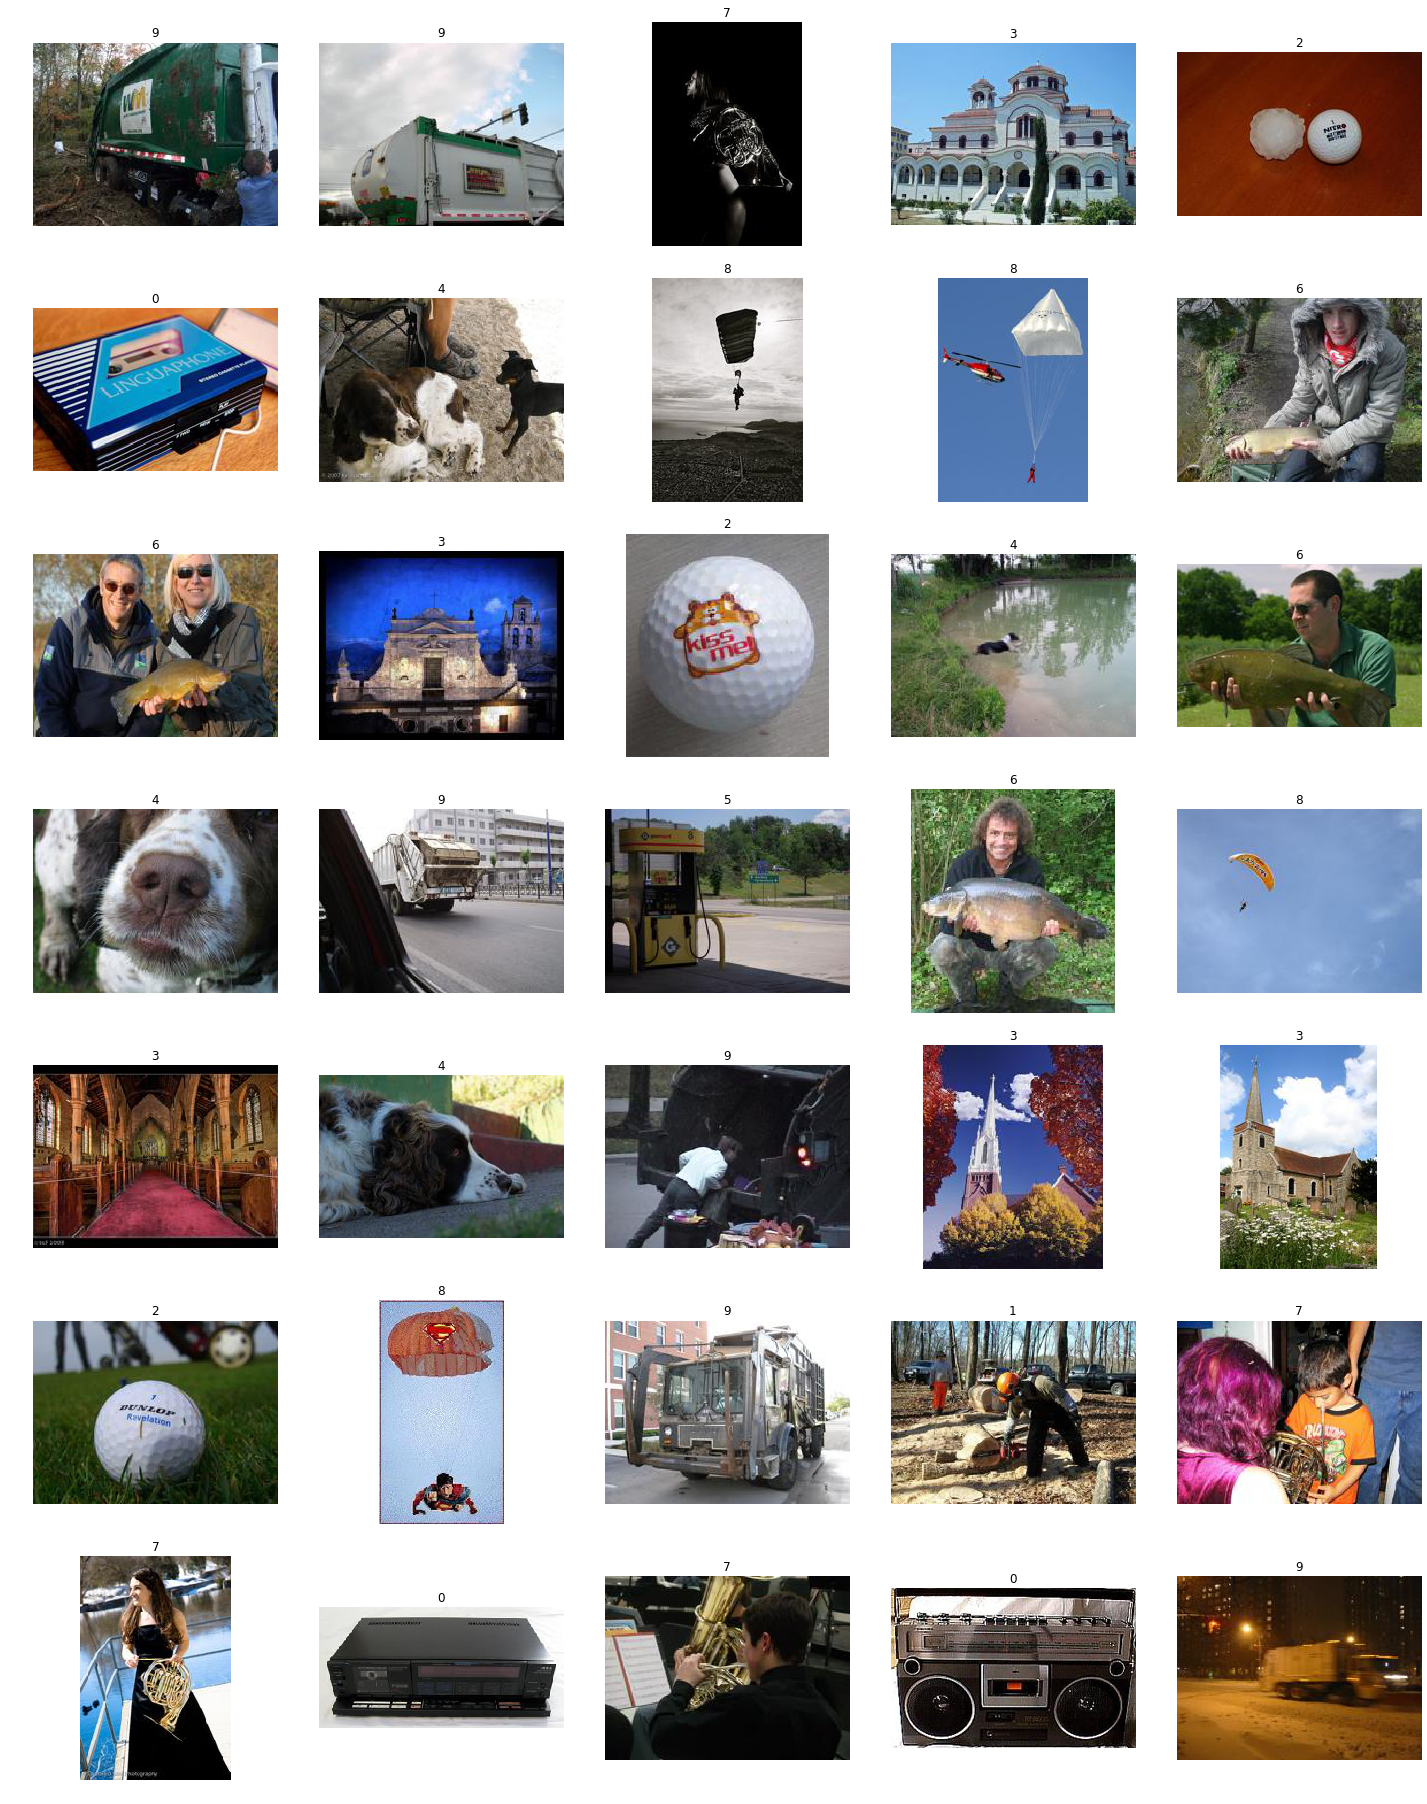

In [48]:
mini_df = df.sample(100)

fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(20, 25))
fig.tight_layout()
axs = [ax for row in axs for ax in row] # Flatten
for img, ax, title in zip([img_open(p) for p in mini_df.path], axs, [cat_norm(l).item() for l in mini_df.label]):
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(title)

In [49]:
cat_map = {
    0: 'chainsaw',
    1: 'golfball',
    2: 'petrol pump',
    3: 'trumbone',
    4: 'speaker',
    5: 'church',
    6: 'parachute',
    7: 'dog',
    8: 'tench',
    9: 'truck'
}

def batch_get_cat(items):
    return [cat_map[item.item()] for item in items]

In [554]:
list(zip(x, batch_get_cat(cat_norm(x, batch=True))))

[('n03000684', 'chainsaw'),
 ('n03445777', 'golfball'),
 ('n02102040', 'dog'),
 ('n03425413', 'petrol pump'),
 ('n02102040', 'dog'),
 ('n03888257', 'parachute'),
 ('n03028079', 'church'),
 ('n03394916', 'trumbone'),
 ('n03394916', 'trumbone'),
 ('n03000684', 'chainsaw')]

In [564]:
df['cat_num'] = cat_norm(df.label, batch=True)
df['cat'] = batch_get_cat(torch.tensor(df['cat_num']))
df.head()

path      label  split  train  \
0  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True   
1  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True   
2  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True   
3  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True   
4  /home/eross/.fastai/data/imagenette-160/train/...  n01440764  train   True   

   cat_num    cat  
0        8  tench  
1        8  tench  
2        8  tench  
3        8  tench  
4        8  tench

# 4. Define the DataLoaders

## 4.1 We could do the mappings in Collate
Note we don't want to use normalize because it happens after collate

In [255]:
# Kind of a flatmap for tensors
class TransformCollate:
    def __init__(self, tfms=[], collate=torch.stack):
        self.tfms = tfms
        self.collate = collate
            
    def __call__(self, items):
        return self.collate([comply(self.tfms, item) for item in items])

In [256]:
img_collate = TransformCollate(img_tfms)

In [257]:
bs=8
train_x = DataLoader(df.path[df.train], bs, collate_fn=img_collate, shuffle=True)

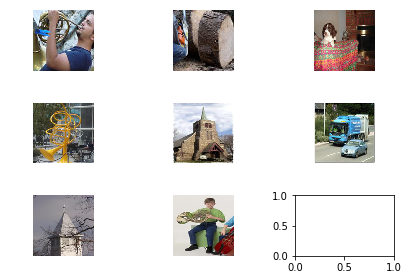

In [258]:
xb = next(iter(train_x))
img_batch_plot(xb, 3, 3)

In [259]:
cat_collate = TransformCollate(cat_tfms)

In [260]:
train_y = DataLoader(df.label[df.train], bs, collate_fn=cat_collate,
                     shuffle=True # This will shuffle in a different way to the x's - which completely breaks it
                    )

In [261]:
yb = next(iter(train_y))
yb, cat_norm.invert(yb, batch=True)

(tensor([9, 5, 7, 6, 0, 4, 7, 1]),
 ['n03417042',
  'n03028079',
  'n02102040',
  'n03888257',
  'n03000684',
  'n02979186',
  'n02102040',
  'n03445777'])

Now we need to combine the collation functions together

In [334]:
class ProductCollate:
    def __init__(self, *collates):
        self.collates = collates
            
    def __call__(self, items):
        items = list(zip(*items))
        assert len(items) == len(self.collates)
        return tuple(collate(item_group) for collate, item_group in zip(self.collates, items))

In [336]:
xy_collate([(df.path[0], df.label[0])])

(tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]]), tensor([8]))

In [337]:
xy_collate = ProductCollate(img_collate, cat_collate)

In [354]:
train = DataLoader(list(zip(df.path[df.train], df.label[df.train])),
                   bs,
                   collate_fn=xy_collate,
                   shuffle=True
                  )

torch.Size([8, 3, 128, 128]) torch.Size([8])


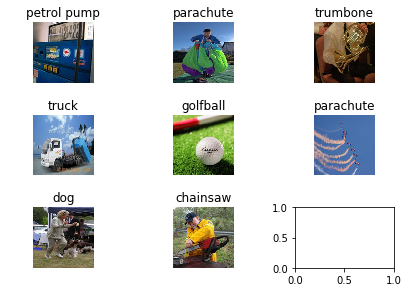

In [566]:
xb, yb = next(iter(train))
print(xb.shape, yb.shape)
img_batch_plot(xb, batch_get_cat(yb), 3, 3)

## 4.2 We could do the mappings in the Dataset

In [521]:
def listify(p=None, q=None):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p=[p]
    elif not isinstance(p, Iterable): p=[p]
    p = list(p)
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

Needs some careful testing...

In [522]:
class ListContainer():
    def __init__(self, items, tfms=None): self.items = listify(items); self.tfms = tfms or []
    def __getitem__(self, idx):
        if isinstance(idx, slice): return self.__class__(self.items[idx], self.tfms)
        try: return comply(self.tfms, self.items[idx])
        except TypeError:
            if isinstance(idx[0],(bool, np.bool_)):
                assert len(idx)==len(self) # bool mask
                return self.__class__([o for m,o in zip(idx,self.items) if m], self.tfms)
            return self.__class__([self.items[i] for i in idx], self.tfms)
        
    def get_inverse(self, idxs):
        if idxs is None: return self
        if isinstance(idxs, slice): idxs = range(len(self))[idxs]
        assert len(idxs) > 0, 'Must pass range of indices'
        if isinstance(idxs[0], (bool, np.bool_)):
            return self[[not x for x in idxs]]
        else:
            return self[[x for x in range(len(self)) if x not in idxs]]
        
    def __len__(self): return len(self.items)
    def __iter__(self): return (comply(self.tfms, x) for x in iter(self.items))
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    # TODO: Check out repr lib in Python
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

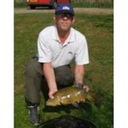

In [512]:
x_items = ListContainer(df.path, img_tfms)
img_from_float(x_items[0])

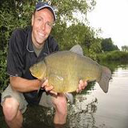

In [513]:
img_from_float(x_items[1])

In [515]:
x_items.__class__([o for m,o in zip(df.train,x_items.items) if m], x_items.tfms)

ListContainer (12894 items)
[PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10026.JPEG'), PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10027.JPEG'), PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10029.JPEG'), PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10040.JPEG'), PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10042.JPEG'), PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10043.JPEG'), PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10048.JPEG'), PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10066.JPEG'), PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_10074.JPEG'), PosixPath('/home/eross/.fastai/data/imagenette-160/train/n01440764/n01440764_1009.JPEG')...]

torch.Size([8, 3, 128, 128])


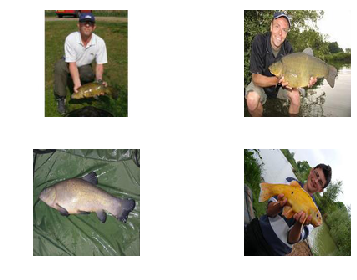

In [517]:
train_x = DataLoader(x_items[df.train], bs)
xb = next(iter(train_x))
print(xb.shape)
img_batch_plot(xb)

In [519]:
train_y = DataLoader(y_items[df.train], bs, shuffle=True)
yb = next(iter(train_y))
yb

tensor([8, 0, 0, 0, 7, 4, 4, 5])

Combining two transforms naively:

In [303]:
def project(f, n):
    return lambda xs: [x if i!=n else f(x) for i, x in enumerate(xs)]

In [304]:
project(lambda x: x+1, 0)([1,2,3])

[2, 2, 3]

In [305]:
# Projection on Cartesian Product
def product_tfms(*tfmses):
    return [project(tfm, i) for i, tfms in enumerate(tfmses) for tfm in tfms]

In [307]:
comply(product_tfms([lambda x: x+1, lambda x: x*3], [lambda x: x-1]), [1,2])

[6, 1]

In [313]:
xy_tfms = product_tfms(img_tfms, cat_tfms)

In [312]:
comply(xy_tfms, (df.path[0], df.label[0]))

[tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor(8)]

In [524]:
items = ListContainer(zip(df.path, df.label), xy_tfms)
items[0]

[tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor(8)]

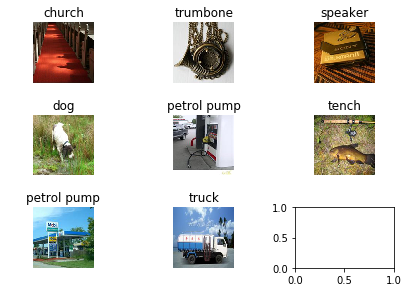

In [567]:
train_dl = DataLoader(items[df.train], bs, shuffle=True)
xb, yb = next(iter(train_dl))
img_batch_plot(xb, batch_get_cat(yb), 3, 3)

# TODO
* One hot encoding/decoding
* Multilabel cateogorical
* Display vs. DataLoader
* **SORT CAT_NORM** (use a dict given 3.6+ insert order?)
* Conjoined transforms
* Projecting dataloaders back down
* Attaching to a model

Transforms at every level (pre-DL, post-DL/pre-collate, post-collate) and their composition

Build out common ItemLists

In [303]:
def project(f, n):
    return lambda xs: [x if i!=n else f(x) for i, x in enumerate(xs)]

In [304]:
project(lambda x: x+1, 0)([1,2,3])

[2, 2, 3]

In [305]:
# Projection on Cartesian Product
def product_tfms(*tfmses):
    return [project(tfm, i) for i, tfms in enumerate(tfmses) for tfm in tfms]

In [307]:
comply(product_tfms([lambda x: x+1, lambda x: x*3], [lambda x: x-1]), [1,2])

[6, 1]

In [313]:
xy_tfms = product_tfms(img_tfms, cat_tfms)